In [ ]:
import torch, os
import torchvision
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np

In [ ]:
########################################################################
# The output of torchvision datasets are PILImage images of range [0, 1].

# Apply necessary image transfromations here 

transform = transforms.Compose([#torchvision.transforms.RandomAffine(degrees=(-10, 10), translate=(0.1, 0.1), scale=(0.8, 1.2)),
                                #torchvision.transforms.ColorJitter(hue=.05, saturation=.05),
                                #torchvision.transforms.RandomHorizontalFlip(),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5, 0.5, 0.5])])
print(transform)

Compose(
    ToTensor()
    Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
)


In [ ]:
train_data_dir = '/content/drive/My Drive/Datasets/3/train' # put path of training dataset
val_data_dir = '/content/drive/My Drive/Datasets/3/val' # put path of validation dataset
test_data_dir = '/content/drive/My Drive/Datasets/3/test' # put path of test dataset

trainset = torchvision.datasets.ImageFolder(root= train_data_dir, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=4)

valset = torchvision.datasets.ImageFolder(root= val_data_dir, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=4,
                                         shuffle=False, num_workers=4)

testset = torchvision.datasets.ImageFolder(root= test_data_dir, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=4)

In [ ]:
########################################################################
# Define a Convolution Neural Network
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Copy the neural network from the Neural Networks section before and modify it to
# take 3-channel images (instead of 1-channel images as it was defined).

import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5)
        self.fc1 = nn.Linear(in_features=256, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=20)      # change out_features according to number of classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = F.avg_pool2d(x, kernel_size=x.shape[2:])
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [ ]:
num_epochs = 50         # desired number of training epochs.
learning_rate = 0.001

In [ ]:
# <<<<<<<<<<<<<<<<<<<<< EDIT THE MODEL DEFINITION >>>>>>>>>>>>>>>>>>>>>>>>>>
# Try experimenting by changing the following:
# 1. number of feature maps in conv layer
# 2. Number of conv layers
# 3. Kernel size
# etc etc.,
   

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=7)
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=7)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=7)
        self.fc3 = nn.Linear(in_features=512, out_features=33)      # change out_features according to number of classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = F.avg_pool2d(x, kernel_size=x.shape[2:])
        x = x.view(x.shape[0], -1)
        x = self.fc3(x)
        return x


In [ ]:
################### DO NOT EDIT THE BELOW CODE!!! #######################

#net = ResNet()
net = Net()

# transfer the model to GPU
if torch.cuda.is_available():
    net = net.cuda()

In [ ]:
import torch.optim as optim

In [ ]:
########################################################################
# Define a Loss function and optimizer
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Let's use a Classification Cross-Entropy loss and SGD with momentum.

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

num_params = np.sum([p.nelement() for p in net.parameters()])
print(num_params, ' parameters')

8064801  parameters


In [ ]:
########################################################################
# Train the network
# ^^^^^^^^^^^^^^^^^^^^

def train(epoch, trainloader, optimizer, criterion):
    running_loss = 0.0
    for i, data in enumerate(tqdm(trainloader), 0):
        # get the inputs
        inputs, labels = data
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print('epoch %d training loss: %.3f' %
            (epoch + 1, running_loss / (len(trainloader))))

In [ ]:
########################################################################
# Let us look at how the network performs on the test dataset.

def test(testloader, model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()        
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images: %d %%' % (
                                    100 * correct / total))

In [ ]:
#########################################################################
# get details of classes and class to index mapping in a directory
def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx

In [ ]:
########################################################################
# class-wise accuracy
def classwise_test(testloader, model):
    classes, _ = find_classes(train_data_dir)
    n_class = len(classes) # number of classes

    class_correct = list(0. for i in range(n_class))
    class_total = list(0. for i in range(n_class))
    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()        
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(n_class):
        print('Accuracy of %10s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

In [ ]:
print('Start Training')
os.makedirs('./models', exist_ok=True)

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print('epoch ', epoch + 1)
    train(epoch, trainloader, optimizer, criterion)
    test(valloader, net)
    classwise_test(valloader, net)
    # save model checkpoint 
    torch.save(net.state_dict(), './models/model-'+str(epoch)+'.pth')      

print('performing test')
test(testloader, net)
classwise_test(testloader, net)

print('Finished Training')

  0%|          | 0/3300 [00:00<?, ?it/s]

Start Training
epoch  1


  0%|          | 0/825 [00:00<?, ?it/s]

epoch 1 training loss: 3.058


  0%|          | 0/825 [00:00<?, ?it/s]

Accuracy of the network on the test images: 23 %


  0%|          | 0/3300 [00:00<?, ?it/s]

Accuracy of arctic_fox : 14 %
Accuracy of     barrel :  0 %
Accuracy of     cannon : 18 %
Accuracy of      chime : 13 %
Accuracy of      cliff :  9 %
Accuracy of       clog :  0 %
Accuracy of      crate :  3 %
Accuracy of    cuirass :  2 %
Accuracy of     dugong : 78 %
Accuracy of        ear : 50 %
Accuracy of frying_pan :  0 %
Accuracy of harvestman : 22 %
Accuracy of    holster :  2 %
Accuracy of horizontal_bar :  0 %
Accuracy of     hotdog : 33 %
Accuracy of       iPod :  1 %
Accuracy of  jellyfish : 53 %
Accuracy of  miniskirt :  9 %
Accuracy of    missile : 14 %
Accuracy of mixing_bowl :  2 %
Accuracy of   nematode :  3 %
Accuracy of newfoundland : 36 %
Accuracy of       oboe :  0 %
Accuracy of      robin :  6 %
Accuracy of     saluki :  0 %
Accuracy of school_bus : 66 %
Accuracy of theater_curtain : 60 %
Accuracy of three_toed_sloth : 46 %
Accuracy of tibetan_mastiff : 61 %
Accuracy of    upright : 62 %
Accuracy of walker_hound : 70 %
Accuracy of        wok :  6 %
Accuracy of wor

  0%|          | 0/825 [00:00<?, ?it/s]

epoch 2 training loss: 2.671


  0%|          | 0/825 [00:00<?, ?it/s]

Accuracy of the network on the test images: 27 %


  0%|          | 0/3300 [00:00<?, ?it/s]

Accuracy of arctic_fox : 37 %
Accuracy of     barrel :  0 %
Accuracy of     cannon : 24 %
Accuracy of      chime : 16 %
Accuracy of      cliff : 24 %
Accuracy of       clog :  0 %
Accuracy of      crate : 30 %
Accuracy of    cuirass : 17 %
Accuracy of     dugong : 68 %
Accuracy of        ear :  9 %
Accuracy of frying_pan :  6 %
Accuracy of harvestman : 10 %
Accuracy of    holster :  0 %
Accuracy of horizontal_bar : 23 %
Accuracy of     hotdog : 51 %
Accuracy of       iPod :  3 %
Accuracy of  jellyfish : 52 %
Accuracy of  miniskirt : 30 %
Accuracy of    missile : 26 %
Accuracy of mixing_bowl : 26 %
Accuracy of   nematode :  6 %
Accuracy of newfoundland :  6 %
Accuracy of       oboe :  7 %
Accuracy of      robin : 54 %
Accuracy of     saluki : 21 %
Accuracy of school_bus : 70 %
Accuracy of theater_curtain : 64 %
Accuracy of three_toed_sloth : 26 %
Accuracy of tibetan_mastiff : 60 %
Accuracy of    upright : 68 %
Accuracy of walker_hound : 26 %
Accuracy of        wok :  1 %
Accuracy of wor

  0%|          | 0/825 [00:00<?, ?it/s]

epoch 3 training loss: 2.436


  0%|          | 0/825 [00:00<?, ?it/s]

Accuracy of the network on the test images: 31 %


  0%|          | 0/3300 [00:00<?, ?it/s]

Accuracy of arctic_fox : 39 %
Accuracy of     barrel :  4 %
Accuracy of     cannon :  7 %
Accuracy of      chime : 18 %
Accuracy of      cliff :  7 %
Accuracy of       clog : 12 %
Accuracy of      crate : 21 %
Accuracy of    cuirass : 19 %
Accuracy of     dugong : 83 %
Accuracy of        ear : 35 %
Accuracy of frying_pan :  1 %
Accuracy of harvestman : 45 %
Accuracy of    holster :  3 %
Accuracy of horizontal_bar : 16 %
Accuracy of     hotdog : 86 %
Accuracy of       iPod : 22 %
Accuracy of  jellyfish : 54 %
Accuracy of  miniskirt :  6 %
Accuracy of    missile : 33 %
Accuracy of mixing_bowl : 32 %
Accuracy of   nematode : 14 %
Accuracy of newfoundland :  7 %
Accuracy of       oboe :  5 %
Accuracy of      robin : 56 %
Accuracy of     saluki : 16 %
Accuracy of school_bus : 73 %
Accuracy of theater_curtain : 66 %
Accuracy of three_toed_sloth : 60 %
Accuracy of tibetan_mastiff : 64 %
Accuracy of    upright : 59 %
Accuracy of walker_hound : 32 %
Accuracy of        wok :  5 %
Accuracy of wor

  0%|          | 0/825 [00:00<?, ?it/s]

epoch 4 training loss: 2.231


  0%|          | 0/825 [00:00<?, ?it/s]

Accuracy of the network on the test images: 34 %


  0%|          | 0/3300 [00:00<?, ?it/s]

Accuracy of arctic_fox : 35 %
Accuracy of     barrel :  3 %
Accuracy of     cannon : 12 %
Accuracy of      chime : 22 %
Accuracy of      cliff : 12 %
Accuracy of       clog :  4 %
Accuracy of      crate : 63 %
Accuracy of    cuirass : 28 %
Accuracy of     dugong : 76 %
Accuracy of        ear : 24 %
Accuracy of frying_pan : 13 %
Accuracy of harvestman : 46 %
Accuracy of    holster : 32 %
Accuracy of horizontal_bar : 39 %
Accuracy of     hotdog : 55 %
Accuracy of       iPod : 26 %
Accuracy of  jellyfish : 64 %
Accuracy of  miniskirt : 33 %
Accuracy of    missile : 18 %
Accuracy of mixing_bowl : 20 %
Accuracy of   nematode : 24 %
Accuracy of newfoundland :  2 %
Accuracy of       oboe : 20 %
Accuracy of      robin : 51 %
Accuracy of     saluki : 50 %
Accuracy of school_bus : 73 %
Accuracy of theater_curtain : 63 %
Accuracy of three_toed_sloth : 61 %
Accuracy of tibetan_mastiff : 55 %
Accuracy of    upright : 38 %
Accuracy of walker_hound : 38 %
Accuracy of        wok : 19 %
Accuracy of wor

  0%|          | 0/825 [00:00<?, ?it/s]

epoch 5 training loss: 2.053


  0%|          | 0/825 [00:00<?, ?it/s]

Accuracy of the network on the test images: 38 %


  0%|          | 0/3300 [00:00<?, ?it/s]

Accuracy of arctic_fox : 50 %
Accuracy of     barrel : 11 %
Accuracy of     cannon : 40 %
Accuracy of      chime : 19 %
Accuracy of      cliff : 20 %
Accuracy of       clog :  9 %
Accuracy of      crate : 51 %
Accuracy of    cuirass : 35 %
Accuracy of     dugong : 61 %
Accuracy of        ear : 19 %
Accuracy of frying_pan : 10 %
Accuracy of harvestman : 53 %
Accuracy of    holster : 30 %
Accuracy of horizontal_bar : 35 %
Accuracy of     hotdog : 50 %
Accuracy of       iPod : 27 %
Accuracy of  jellyfish : 55 %
Accuracy of  miniskirt : 30 %
Accuracy of    missile : 40 %
Accuracy of mixing_bowl : 44 %
Accuracy of   nematode : 24 %
Accuracy of newfoundland : 54 %
Accuracy of       oboe : 18 %
Accuracy of      robin : 67 %
Accuracy of     saluki : 15 %
Accuracy of school_bus : 93 %
Accuracy of theater_curtain : 69 %
Accuracy of three_toed_sloth : 31 %
Accuracy of tibetan_mastiff : 43 %
Accuracy of    upright : 52 %
Accuracy of walker_hound : 31 %
Accuracy of        wok : 33 %
Accuracy of wor

  0%|          | 0/825 [00:00<?, ?it/s]

epoch 6 training loss: 1.860


  0%|          | 0/825 [00:00<?, ?it/s]

Accuracy of the network on the test images: 39 %


  0%|          | 0/3300 [00:00<?, ?it/s]

Accuracy of arctic_fox : 54 %
Accuracy of     barrel :  2 %
Accuracy of     cannon : 26 %
Accuracy of      chime : 14 %
Accuracy of      cliff : 33 %
Accuracy of       clog : 28 %
Accuracy of      crate : 45 %
Accuracy of    cuirass : 40 %
Accuracy of     dugong : 91 %
Accuracy of        ear : 58 %
Accuracy of frying_pan :  9 %
Accuracy of harvestman : 59 %
Accuracy of    holster : 27 %
Accuracy of horizontal_bar : 38 %
Accuracy of     hotdog : 60 %
Accuracy of       iPod : 34 %
Accuracy of  jellyfish : 40 %
Accuracy of  miniskirt : 28 %
Accuracy of    missile : 30 %
Accuracy of mixing_bowl : 43 %
Accuracy of   nematode : 13 %
Accuracy of newfoundland : 67 %
Accuracy of       oboe : 14 %
Accuracy of      robin : 47 %
Accuracy of     saluki : 38 %
Accuracy of school_bus : 79 %
Accuracy of theater_curtain : 62 %
Accuracy of three_toed_sloth : 33 %
Accuracy of tibetan_mastiff : 43 %
Accuracy of    upright : 52 %
Accuracy of walker_hound : 41 %
Accuracy of        wok : 12 %
Accuracy of wor

  0%|          | 0/825 [00:00<?, ?it/s]

epoch 7 training loss: 1.666


  0%|          | 0/825 [00:00<?, ?it/s]

Accuracy of the network on the test images: 38 %


  0%|          | 0/3300 [00:00<?, ?it/s]

Accuracy of arctic_fox : 23 %
Accuracy of     barrel :  1 %
Accuracy of     cannon : 12 %
Accuracy of      chime :  5 %
Accuracy of      cliff : 29 %
Accuracy of       clog : 24 %
Accuracy of      crate : 61 %
Accuracy of    cuirass : 19 %
Accuracy of     dugong : 82 %
Accuracy of        ear : 35 %
Accuracy of frying_pan : 17 %
Accuracy of harvestman : 69 %
Accuracy of    holster : 50 %
Accuracy of horizontal_bar : 46 %
Accuracy of     hotdog : 42 %
Accuracy of       iPod : 29 %
Accuracy of  jellyfish : 55 %
Accuracy of  miniskirt : 41 %
Accuracy of    missile : 58 %
Accuracy of mixing_bowl : 49 %
Accuracy of   nematode : 19 %
Accuracy of newfoundland : 13 %
Accuracy of       oboe : 14 %
Accuracy of      robin : 59 %
Accuracy of     saluki : 29 %
Accuracy of school_bus : 91 %
Accuracy of theater_curtain : 64 %
Accuracy of three_toed_sloth : 22 %
Accuracy of tibetan_mastiff : 68 %
Accuracy of    upright : 62 %
Accuracy of walker_hound : 40 %
Accuracy of        wok : 14 %
Accuracy of wor

  0%|          | 0/825 [00:00<?, ?it/s]

epoch 8 training loss: 1.460


  0%|          | 0/825 [00:00<?, ?it/s]

Accuracy of the network on the test images: 43 %


  0%|          | 0/3300 [00:00<?, ?it/s]

Accuracy of arctic_fox : 39 %
Accuracy of     barrel : 10 %
Accuracy of     cannon : 18 %
Accuracy of      chime : 20 %
Accuracy of      cliff : 34 %
Accuracy of       clog : 13 %
Accuracy of      crate : 48 %
Accuracy of    cuirass : 51 %
Accuracy of     dugong : 88 %
Accuracy of        ear : 32 %
Accuracy of frying_pan : 52 %
Accuracy of harvestman : 69 %
Accuracy of    holster : 27 %
Accuracy of horizontal_bar : 45 %
Accuracy of     hotdog : 66 %
Accuracy of       iPod : 33 %
Accuracy of  jellyfish : 50 %
Accuracy of  miniskirt : 38 %
Accuracy of    missile : 62 %
Accuracy of mixing_bowl : 41 %
Accuracy of   nematode : 30 %
Accuracy of newfoundland : 33 %
Accuracy of       oboe : 36 %
Accuracy of      robin : 56 %
Accuracy of     saluki : 42 %
Accuracy of school_bus : 85 %
Accuracy of theater_curtain : 50 %
Accuracy of three_toed_sloth : 60 %
Accuracy of tibetan_mastiff : 72 %
Accuracy of    upright : 46 %
Accuracy of walker_hound : 49 %
Accuracy of        wok :  7 %
Accuracy of wor

  0%|          | 0/825 [00:00<?, ?it/s]

epoch 9 training loss: 1.249


  0%|          | 0/825 [00:00<?, ?it/s]

Accuracy of the network on the test images: 42 %


  0%|          | 0/3300 [00:00<?, ?it/s]

Accuracy of arctic_fox : 46 %
Accuracy of     barrel : 11 %
Accuracy of     cannon : 36 %
Accuracy of      chime : 19 %
Accuracy of      cliff : 39 %
Accuracy of       clog : 24 %
Accuracy of      crate : 45 %
Accuracy of    cuirass : 45 %
Accuracy of     dugong : 73 %
Accuracy of        ear : 26 %
Accuracy of frying_pan : 14 %
Accuracy of harvestman : 68 %
Accuracy of    holster : 22 %
Accuracy of horizontal_bar : 36 %
Accuracy of     hotdog : 74 %
Accuracy of       iPod : 19 %
Accuracy of  jellyfish : 66 %
Accuracy of  miniskirt : 19 %
Accuracy of    missile : 32 %
Accuracy of mixing_bowl : 47 %
Accuracy of   nematode : 19 %
Accuracy of newfoundland : 36 %
Accuracy of       oboe : 48 %
Accuracy of      robin : 74 %
Accuracy of     saluki : 25 %
Accuracy of school_bus : 74 %
Accuracy of theater_curtain : 62 %
Accuracy of three_toed_sloth : 68 %
Accuracy of tibetan_mastiff : 66 %
Accuracy of    upright : 56 %
Accuracy of walker_hound : 38 %
Accuracy of        wok : 29 %
Accuracy of wor

  0%|          | 0/825 [00:00<?, ?it/s]

epoch 10 training loss: 1.026


  0%|          | 0/825 [00:00<?, ?it/s]

Accuracy of the network on the test images: 43 %


  0%|          | 0/3300 [00:00<?, ?it/s]

Accuracy of arctic_fox : 55 %
Accuracy of     barrel : 16 %
Accuracy of     cannon : 33 %
Accuracy of      chime : 18 %
Accuracy of      cliff : 33 %
Accuracy of       clog : 10 %
Accuracy of      crate : 27 %
Accuracy of    cuirass : 18 %
Accuracy of     dugong : 77 %
Accuracy of        ear : 56 %
Accuracy of frying_pan : 13 %
Accuracy of harvestman : 76 %
Accuracy of    holster : 13 %
Accuracy of horizontal_bar : 15 %
Accuracy of     hotdog : 60 %
Accuracy of       iPod : 45 %
Accuracy of  jellyfish : 64 %
Accuracy of  miniskirt : 25 %
Accuracy of    missile : 31 %
Accuracy of mixing_bowl : 53 %
Accuracy of   nematode : 38 %
Accuracy of newfoundland : 44 %
Accuracy of       oboe : 59 %
Accuracy of      robin : 67 %
Accuracy of     saluki : 50 %
Accuracy of school_bus : 82 %
Accuracy of theater_curtain : 79 %
Accuracy of three_toed_sloth : 56 %
Accuracy of tibetan_mastiff : 56 %
Accuracy of    upright : 50 %
Accuracy of walker_hound : 42 %
Accuracy of        wok : 21 %
Accuracy of wor

  0%|          | 0/825 [00:00<?, ?it/s]

epoch 11 training loss: 0.825


  0%|          | 0/825 [00:00<?, ?it/s]

Accuracy of the network on the test images: 43 %


  0%|          | 0/3300 [00:00<?, ?it/s]

Accuracy of arctic_fox : 48 %
Accuracy of     barrel : 11 %
Accuracy of     cannon : 18 %
Accuracy of      chime : 45 %
Accuracy of      cliff : 44 %
Accuracy of       clog : 45 %
Accuracy of      crate : 25 %
Accuracy of    cuirass : 45 %
Accuracy of     dugong : 81 %
Accuracy of        ear : 67 %
Accuracy of frying_pan : 20 %
Accuracy of harvestman : 64 %
Accuracy of    holster : 17 %
Accuracy of horizontal_bar : 38 %
Accuracy of     hotdog : 48 %
Accuracy of       iPod : 28 %
Accuracy of  jellyfish : 59 %
Accuracy of  miniskirt : 28 %
Accuracy of    missile : 39 %
Accuracy of mixing_bowl : 46 %
Accuracy of   nematode : 34 %
Accuracy of newfoundland : 44 %
Accuracy of       oboe : 28 %
Accuracy of      robin : 66 %
Accuracy of     saluki : 30 %
Accuracy of school_bus : 82 %
Accuracy of theater_curtain : 61 %
Accuracy of three_toed_sloth : 53 %
Accuracy of tibetan_mastiff : 62 %
Accuracy of    upright : 51 %
Accuracy of walker_hound : 33 %
Accuracy of        wok : 12 %
Accuracy of wor

  0%|          | 0/825 [00:00<?, ?it/s]

epoch 12 training loss: 0.607


  0%|          | 0/825 [00:00<?, ?it/s]

Accuracy of the network on the test images: 42 %


  0%|          | 0/3300 [00:00<?, ?it/s]

Accuracy of arctic_fox : 31 %
Accuracy of     barrel : 23 %
Accuracy of     cannon : 19 %
Accuracy of      chime : 24 %
Accuracy of      cliff : 47 %
Accuracy of       clog : 31 %
Accuracy of      crate : 25 %
Accuracy of    cuirass : 22 %
Accuracy of     dugong : 73 %
Accuracy of        ear : 50 %
Accuracy of frying_pan : 35 %
Accuracy of harvestman : 68 %
Accuracy of    holster : 28 %
Accuracy of horizontal_bar : 39 %
Accuracy of     hotdog : 50 %
Accuracy of       iPod : 30 %
Accuracy of  jellyfish : 57 %
Accuracy of  miniskirt : 35 %
Accuracy of    missile : 30 %
Accuracy of mixing_bowl : 38 %
Accuracy of   nematode : 41 %
Accuracy of newfoundland : 36 %
Accuracy of       oboe : 22 %
Accuracy of      robin : 61 %
Accuracy of     saluki : 45 %
Accuracy of school_bus : 80 %
Accuracy of theater_curtain : 71 %
Accuracy of three_toed_sloth : 53 %
Accuracy of tibetan_mastiff : 70 %
Accuracy of    upright : 48 %
Accuracy of walker_hound : 37 %
Accuracy of        wok : 15 %
Accuracy of wor

  0%|          | 0/825 [00:00<?, ?it/s]

epoch 13 training loss: 0.456


  0%|          | 0/825 [00:00<?, ?it/s]

Accuracy of the network on the test images: 43 %


  0%|          | 0/3300 [00:00<?, ?it/s]

Accuracy of arctic_fox : 50 %
Accuracy of     barrel : 17 %
Accuracy of     cannon : 22 %
Accuracy of      chime : 44 %
Accuracy of      cliff : 39 %
Accuracy of       clog : 17 %
Accuracy of      crate : 45 %
Accuracy of    cuirass : 40 %
Accuracy of     dugong : 87 %
Accuracy of        ear : 54 %
Accuracy of frying_pan : 27 %
Accuracy of harvestman : 73 %
Accuracy of    holster : 40 %
Accuracy of horizontal_bar : 46 %
Accuracy of     hotdog : 41 %
Accuracy of       iPod : 20 %
Accuracy of  jellyfish : 47 %
Accuracy of  miniskirt : 39 %
Accuracy of    missile : 41 %
Accuracy of mixing_bowl : 58 %
Accuracy of   nematode : 29 %
Accuracy of newfoundland : 38 %
Accuracy of       oboe : 30 %
Accuracy of      robin : 66 %
Accuracy of     saluki : 37 %
Accuracy of school_bus : 75 %
Accuracy of theater_curtain : 74 %
Accuracy of three_toed_sloth : 39 %
Accuracy of tibetan_mastiff : 29 %
Accuracy of    upright : 54 %
Accuracy of walker_hound : 43 %
Accuracy of        wok : 21 %
Accuracy of wor

  0%|          | 0/825 [00:00<?, ?it/s]

epoch 14 training loss: 0.346


  0%|          | 0/825 [00:00<?, ?it/s]

Accuracy of the network on the test images: 41 %


  0%|          | 0/3300 [00:00<?, ?it/s]

Accuracy of arctic_fox : 55 %
Accuracy of     barrel :  9 %
Accuracy of     cannon : 37 %
Accuracy of      chime : 32 %
Accuracy of      cliff : 37 %
Accuracy of       clog : 15 %
Accuracy of      crate : 24 %
Accuracy of    cuirass : 41 %
Accuracy of     dugong : 43 %
Accuracy of        ear : 42 %
Accuracy of frying_pan : 39 %
Accuracy of harvestman : 67 %
Accuracy of    holster : 31 %
Accuracy of horizontal_bar : 40 %
Accuracy of     hotdog : 27 %
Accuracy of       iPod : 42 %
Accuracy of  jellyfish : 79 %
Accuracy of  miniskirt : 35 %
Accuracy of    missile : 32 %
Accuracy of mixing_bowl : 71 %
Accuracy of   nematode : 22 %
Accuracy of newfoundland : 35 %
Accuracy of       oboe : 41 %
Accuracy of      robin : 65 %
Accuracy of     saluki : 40 %
Accuracy of school_bus : 68 %
Accuracy of theater_curtain : 62 %
Accuracy of three_toed_sloth : 53 %
Accuracy of tibetan_mastiff : 63 %
Accuracy of    upright : 41 %
Accuracy of walker_hound : 45 %
Accuracy of        wok :  7 %
Accuracy of wor

  0%|          | 0/825 [00:00<?, ?it/s]

epoch 15 training loss: 0.296


  0%|          | 0/825 [00:00<?, ?it/s]

Accuracy of the network on the test images: 44 %


  0%|          | 0/3300 [00:00<?, ?it/s]

Accuracy of arctic_fox : 43 %
Accuracy of     barrel :  9 %
Accuracy of     cannon : 37 %
Accuracy of      chime : 16 %
Accuracy of      cliff : 50 %
Accuracy of       clog : 27 %
Accuracy of      crate : 28 %
Accuracy of    cuirass : 43 %
Accuracy of     dugong : 84 %
Accuracy of        ear : 47 %
Accuracy of frying_pan : 29 %
Accuracy of harvestman : 74 %
Accuracy of    holster : 19 %
Accuracy of horizontal_bar : 55 %
Accuracy of     hotdog : 66 %
Accuracy of       iPod : 25 %
Accuracy of  jellyfish : 64 %
Accuracy of  miniskirt : 30 %
Accuracy of    missile : 41 %
Accuracy of mixing_bowl : 49 %
Accuracy of   nematode : 37 %
Accuracy of newfoundland : 41 %
Accuracy of       oboe : 21 %
Accuracy of      robin : 65 %
Accuracy of     saluki : 41 %
Accuracy of school_bus : 69 %
Accuracy of theater_curtain : 73 %
Accuracy of three_toed_sloth : 70 %
Accuracy of tibetan_mastiff : 66 %
Accuracy of    upright : 48 %
Accuracy of walker_hound : 56 %
Accuracy of        wok : 13 %
Accuracy of wor

  0%|          | 0/825 [00:00<?, ?it/s]

epoch 16 training loss: 0.242


  0%|          | 0/825 [00:00<?, ?it/s]

Accuracy of the network on the test images: 44 %


  0%|          | 0/3300 [00:00<?, ?it/s]

Accuracy of arctic_fox : 44 %
Accuracy of     barrel : 15 %
Accuracy of     cannon : 22 %
Accuracy of      chime : 26 %
Accuracy of      cliff : 20 %
Accuracy of       clog : 30 %
Accuracy of      crate : 40 %
Accuracy of    cuirass : 42 %
Accuracy of     dugong : 78 %
Accuracy of        ear : 46 %
Accuracy of frying_pan : 36 %
Accuracy of harvestman : 73 %
Accuracy of    holster : 29 %
Accuracy of horizontal_bar : 43 %
Accuracy of     hotdog : 48 %
Accuracy of       iPod : 37 %
Accuracy of  jellyfish : 67 %
Accuracy of  miniskirt : 36 %
Accuracy of    missile : 41 %
Accuracy of mixing_bowl : 56 %
Accuracy of   nematode : 42 %
Accuracy of newfoundland : 33 %
Accuracy of       oboe : 34 %
Accuracy of      robin : 66 %
Accuracy of     saluki : 40 %
Accuracy of school_bus : 80 %
Accuracy of theater_curtain : 77 %
Accuracy of three_toed_sloth : 60 %
Accuracy of tibetan_mastiff : 63 %
Accuracy of    upright : 45 %
Accuracy of walker_hound : 29 %
Accuracy of        wok : 15 %
Accuracy of wor

  0%|          | 0/825 [00:00<?, ?it/s]

epoch 17 training loss: 0.175


  0%|          | 0/825 [00:00<?, ?it/s]

Accuracy of the network on the test images: 44 %


  0%|          | 0/3300 [00:00<?, ?it/s]

Accuracy of arctic_fox : 53 %
Accuracy of     barrel : 11 %
Accuracy of     cannon : 31 %
Accuracy of      chime : 28 %
Accuracy of      cliff : 39 %
Accuracy of       clog : 16 %
Accuracy of      crate : 40 %
Accuracy of    cuirass : 39 %
Accuracy of     dugong : 78 %
Accuracy of        ear : 63 %
Accuracy of frying_pan : 33 %
Accuracy of harvestman : 70 %
Accuracy of    holster : 28 %
Accuracy of horizontal_bar : 45 %
Accuracy of     hotdog : 47 %
Accuracy of       iPod : 49 %
Accuracy of  jellyfish : 62 %
Accuracy of  miniskirt : 31 %
Accuracy of    missile : 27 %
Accuracy of mixing_bowl : 52 %
Accuracy of   nematode : 43 %
Accuracy of newfoundland : 29 %
Accuracy of       oboe : 19 %
Accuracy of      robin : 77 %
Accuracy of     saluki : 36 %
Accuracy of school_bus : 81 %
Accuracy of theater_curtain : 78 %
Accuracy of three_toed_sloth : 58 %
Accuracy of tibetan_mastiff : 55 %
Accuracy of    upright : 49 %
Accuracy of walker_hound : 38 %
Accuracy of        wok : 23 %
Accuracy of wor

  0%|          | 0/825 [00:00<?, ?it/s]

epoch 18 training loss: 0.161


  0%|          | 0/825 [00:00<?, ?it/s]

Accuracy of the network on the test images: 44 %


  0%|          | 0/3300 [00:00<?, ?it/s]

Accuracy of arctic_fox : 63 %
Accuracy of     barrel : 16 %
Accuracy of     cannon : 26 %
Accuracy of      chime : 12 %
Accuracy of      cliff : 35 %
Accuracy of       clog : 28 %
Accuracy of      crate : 36 %
Accuracy of    cuirass : 38 %
Accuracy of     dugong : 79 %
Accuracy of        ear : 51 %
Accuracy of frying_pan : 29 %
Accuracy of harvestman : 68 %
Accuracy of    holster : 28 %
Accuracy of horizontal_bar : 52 %
Accuracy of     hotdog : 48 %
Accuracy of       iPod : 41 %
Accuracy of  jellyfish : 46 %
Accuracy of  miniskirt : 33 %
Accuracy of    missile : 40 %
Accuracy of mixing_bowl : 55 %
Accuracy of   nematode : 41 %
Accuracy of newfoundland : 26 %
Accuracy of       oboe : 33 %
Accuracy of      robin : 77 %
Accuracy of     saluki : 39 %
Accuracy of school_bus : 79 %
Accuracy of theater_curtain : 72 %
Accuracy of three_toed_sloth : 59 %
Accuracy of tibetan_mastiff : 46 %
Accuracy of    upright : 62 %
Accuracy of walker_hound : 39 %
Accuracy of        wok : 34 %
Accuracy of wor

  0%|          | 0/825 [00:00<?, ?it/s]

epoch 19 training loss: 0.107


  0%|          | 0/825 [00:00<?, ?it/s]

Accuracy of the network on the test images: 45 %


  0%|          | 0/3300 [00:00<?, ?it/s]

Accuracy of arctic_fox : 49 %
Accuracy of     barrel : 30 %
Accuracy of     cannon : 20 %
Accuracy of      chime : 32 %
Accuracy of      cliff : 40 %
Accuracy of       clog : 32 %
Accuracy of      crate : 30 %
Accuracy of    cuirass : 48 %
Accuracy of     dugong : 83 %
Accuracy of        ear : 52 %
Accuracy of frying_pan : 24 %
Accuracy of harvestman : 69 %
Accuracy of    holster : 28 %
Accuracy of horizontal_bar : 41 %
Accuracy of     hotdog : 64 %
Accuracy of       iPod : 27 %
Accuracy of  jellyfish : 57 %
Accuracy of  miniskirt : 27 %
Accuracy of    missile : 41 %
Accuracy of mixing_bowl : 51 %
Accuracy of   nematode : 34 %
Accuracy of newfoundland : 33 %
Accuracy of       oboe : 40 %
Accuracy of      robin : 69 %
Accuracy of     saluki : 39 %
Accuracy of school_bus : 82 %
Accuracy of theater_curtain : 74 %
Accuracy of three_toed_sloth : 54 %
Accuracy of tibetan_mastiff : 72 %
Accuracy of    upright : 56 %
Accuracy of walker_hound : 53 %
Accuracy of        wok : 20 %
Accuracy of wor

  0%|          | 0/825 [00:00<?, ?it/s]

epoch 20 training loss: 0.076


  0%|          | 0/825 [00:00<?, ?it/s]

Accuracy of the network on the test images: 45 %


  0%|          | 0/3300 [00:00<?, ?it/s]

Accuracy of arctic_fox : 46 %
Accuracy of     barrel : 13 %
Accuracy of     cannon : 38 %
Accuracy of      chime : 37 %
Accuracy of      cliff : 44 %
Accuracy of       clog : 24 %
Accuracy of      crate : 45 %
Accuracy of    cuirass : 54 %
Accuracy of     dugong : 60 %
Accuracy of        ear : 42 %
Accuracy of frying_pan : 31 %
Accuracy of harvestman : 65 %
Accuracy of    holster : 28 %
Accuracy of horizontal_bar : 37 %
Accuracy of     hotdog : 54 %
Accuracy of       iPod : 32 %
Accuracy of  jellyfish : 69 %
Accuracy of  miniskirt : 29 %
Accuracy of    missile : 35 %
Accuracy of mixing_bowl : 45 %
Accuracy of   nematode : 36 %
Accuracy of newfoundland : 34 %
Accuracy of       oboe : 39 %
Accuracy of      robin : 68 %
Accuracy of     saluki : 42 %
Accuracy of school_bus : 91 %
Accuracy of theater_curtain : 77 %
Accuracy of three_toed_sloth : 72 %
Accuracy of tibetan_mastiff : 52 %
Accuracy of    upright : 54 %
Accuracy of walker_hound : 39 %
Accuracy of        wok : 26 %
Accuracy of wor

  0%|          | 0/825 [00:00<?, ?it/s]

epoch 21 training loss: 0.079


  0%|          | 0/825 [00:00<?, ?it/s]

Accuracy of the network on the test images: 44 %


 25%|██▍       | 205/825 [00:01<00:05, 123.59it/s]

In [ ]:
torch.save(net.state_dict(), './models/Final_Model_2.pth')

In [ ]:
torch.save(net.state_dict(), '/content/drive/My Drive/Datasets/Final_Model_2.pth')

In [ ]:
import seaborn as sns

class Net2(nn.Module):
    def __init__(self):
        super(Net2, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=5, stride=3)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5)
        self.fc1 = nn.Linear(in_features=256, out_features=33)      # change out_features according to number of classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = F.avg_pool2d(x, kernel_size=x.shape[2:])
        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        return x

#net = ResNet()
net2 = Net2()

# transfer the model to GPU
if torch.cuda.is_available():
    net2 = net2.cuda()

criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.SGD(net2.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

num_params = np.sum([p.nelement() for p in net2.parameters()])
print(num_params, ' parameters')

num_epochs2 = 100

def train2(epoch, trainloader, optimizer, criterion):
    running_loss = 0.0
    for i, data in enumerate(tqdm(trainloader), 0):
        # get the inputs
        inputs, labels = data
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net2(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

    print('epoch %d training loss: %.3f' %
            (epoch + 1, running_loss / (len(trainloader))))

def test2(testloader, model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()        
            outputs = net2(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images: %d %%' % (
                                    100 * correct / total))
    return (100*correct/total)

def classwise_test2(testloader, model):
    classes, _ = find_classes(train_data_dir)
    n_class = len(classes) # number of classes

    class_correct = list(0. for i in range(n_class))
    class_total = list(0. for i in range(n_class))
    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()        
            outputs = net2(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(n_class):
        print('Accuracy of %10s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

train_errors = []
val_errors = []

print('Start Training')
os.makedirs('./models', exist_ok=True)

for epoch in range(num_epochs2):  # loop over the dataset multiple times
    print('epoch ', epoch + 1)
    train2(epoch, trainloader, optimizer2, criterion2)
    test2(valloader, net2)
    classwise_test2(valloader, net2)
    # save model checkpoint 
    torch.save(net2.state_dict(), './models/model2-'+str(epoch)+'.pth')      

print('performing test')
test2(testloader, net2)
classwise_test2(testloader, net2)

print('Finished Training')

In [ ]:
import os
k=0
folder = "/content/drive/My Drive/Datasets/3/test/theater_curtain/"
for filename in os.listdir(folder):
  img = Image.open(folder + filename)
  trans1 = transforms.ToTensor()
  tensor = trans1(img)
  input = (tensor.unsqueeze(0)).cuda()
  output = net(input)  
  if not (torch.eq(torch.max(output[0]), output[0][10])):
    k+=1
    print(filename)
  if k ==2:
    break

n0441835700000851.jpg
n0441835700000843.jpg


In [ ]:
img = Image.open("/content/drive/My Drive/Datasets/3/test/theater_curtain/n0441835700000851.jpg")
print(type(img))
trans1 = transforms.ToTensor()
tensor = trans1(img)
input = (tensor.unsqueeze(0)).cuda()
output = net(input)  
print(torch.max(output[0]))
print(output[0])
print(torch.eq(torch.max(output[0]), output[0][10]))

<class 'PIL.JpegImagePlugin.JpegImageFile'>
tensor(9.3926, device='cuda:0', grad_fn=<MaxBackward1>)
tensor([-0.6653, -3.5559, -0.4938,  4.4987,  1.6962,  1.1809,  2.0780, -2.0070,
         3.8930, -0.1977, -3.6705,  5.0937, -2.3125, -0.0881, -6.9735,  1.5067,
         4.9451, -1.2821,  1.4358,  4.8600,  9.3926, -2.0716,  1.0182, -2.1787,
        -2.4436, -0.8348, -0.9974, -2.0181, -6.4050, -3.1676, -1.5695, -4.5216,
         5.8049], device='cuda:0', grad_fn=<SelectBackward>)
tensor(False, device='cuda:0')


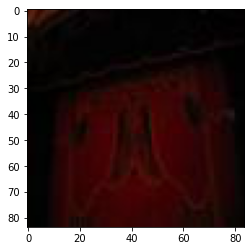

In [ ]:
plt.imshow(img)